<a href="https://colab.research.google.com/github/datacommonsorg/api-python/blob/master/notebooks/Analyzing_SuperfundSites_with_Data_Commons.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Copyright 2022 Google LLC.
SPDX-License-Identifier: Apache-2.0

**Notebook Version** - 1.0.0

## Analyzing SuperfundSites with Data Commons

This information, stored in Data Commons, is available to everyone for data science projects, education, and exploration. 

This tutorial introduces the Data Commons graph and two of its tools: (1) the [browser](https://browser.datacommons.org/) and (2) the [Pandas API](https://github.com/datacommonsorg/api-pandas).

### Data Commons Browser

The [Data Commons browser](https://browser.datacommons.org/) provides a way to explore the data in a human-readable format. It is the best way to explore what is in Data Commons. 

An important property for all entities is the **`dcid`**. The `dcid` (Data Commons identifier) is a unique identifier assigned to each entity in the knowledge graph. With this identifier, one will be able to search for and query information on the given entity in ways that we will discuss later. The `dcid` is listed at the top of the page next to "About: " and also in the list of properties.

### Accessing statistics through APIs
Currently there are three ways in which statistics from then Data Commons graph can be obtained, namely:

1. [Python API](https://docs.datacommons.org/api/python/) - a lightweight python wrapper 
2. The [Pandas API](https://github.com/datacommonsorg/api-pandas) provides functions for users to extract structured information from Data Commons programmatically and view them in different formats such as Python dicts and [pandas](https://pandas.pydata.org/) DataFrames. DataFrames allow access to all the data processing, analytical and visualization tools provided by packages such as pandas, NumPy, SciPy, and Matplotlib.
3. [REST API endpoints](https://docs.datacommons.org/api/rest/) - a common, language agnostic means to access stats

### About this notebook
This notebook presents how different Data Commons APIs work with example snippets to extract statistics from the knowledge graph. The notebook will provide code snippets that can better showcase how data can be used for visualization and analysis. Specifically, the notebook uses statistics available on Superfund Sites and Demographics as examples, but the snippets can be used for statistics in other verticals like Climate, Economics, Health, etc.



In [ ]:
# Refer: https://docs.datacommons.org/api/pandas/
!pip install datacommons_pandas datacommons geopandas plotly descartes --upgrade --quiet

# Import Data Commons
import datacommons as dc
import datacommons_pandas as dpd

# Import other required libraries
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import plotly.express as px
from descartes import PolygonPatch

import ipywidgets as widgets
import pprint
import requests
import json

# setting place scope to US
_USA = 'country/USA'

### Querying Statistics from Data Commons

Data Commons has a large corpus of statistical data, which can be queried and joined with other statistics. For example, we can query the  median income of women living in Berkeley, California or the number of individuals who are insured in Maryland. 

Before we explore how to do this, we need to understand how Data Commons stores statistical data. In particular, there are two types of entities: [StatisticalVariable](https://browser.datacommons.org/kg?dcid=StatisticalVariable) and [StatVarObservation](https://browser.datacommons.org/kg?dcid=StatVarObservation).

A StatisticalVariable represents any type of statistical metric that can be measured at a place and time. Some examples include: median income, median income of females, number of high school graduates, unemployment rate, prevalence of diabetes, essentially anything one might call a metric, statistic, or measure. A StatVarObservation represents an actual measurement of a StatisticalVariable in a given place and time.

One example of a StatisticalVariable is the median age of people in San Antonio, Texas in 2014. The statistical metric, time, and place here are median age, 2014, and San Antonio respectively. A list of StatisticalVariables can be found [here](http://docs.datacommons.org/statistical_variables.html). To read more about StatisticalVariable and StatVarObservation, please see [representing_statistics.md](https://github.com/datacommonsorg/data/blob/master/docs/representing_statistics.md).

Data Commons defines APIs allowing us to fetch data over these two types. To begin with, we can use the [**`build_multivariate_dataframe`**](https://docs.datacommons.org/api/pandas/multivariate_dataframe.html) function to build a dataframe with the latest StatVarObservations of multiple StatisticalVariables for multiple places.

Now, we start of with some code snippets where we use the Data Commons API to pull out statistics from the Data Commons graph.

## Demo 1 - List of all superfund sites

In this first demo, we will be starting off by getting all the [superfund sites](https://en.wikipedia.org/wiki/List_of_Superfund_sites) that are located across the United States. Since, we will be fetching statistics from the United States, we have pre-defined the base place in variable `usa` with the value `country/USA`. 

Note: `country/USA` is a unique identifier to a node on the Data Commons Graph which defines [United States](https://datacommons.org/browser/country/USA)

In [ ]:
#@title Select place types

#@markdown *Select `Runtime > Run all` from the menu above after filling up the values.*

#@markdown Select a geo-level for querying statistics. Select 'State' for a quick demo
US_GEO_LEVEL = 'State' #@param ["State", "Country", "County"] {allow-input: true}

Now, that a GEO_LEVEL is selected for viewing different statistics, we shall fetch all the places within the GEO_LEVEL that are present in the Data Commons Graph.

### Get places contained in the selected place type

So, if "State" is selected as the GEO_LEVEL, we will get a list of Data Common Graph ids for all the States in the US. Where each place id refers to a unique node on the graph which describes the place with different constraint properties, like the `typeOf` place which quantifies if the place is a State, or other administrative division applicable. 

This is done using the [`get_places_in`](https://docs.datacommons.org/api/python/place_in.html) API method.

In [ ]:
# get the dcids for all the places in the selected place type across US
if US_GEO_LEVEL == 'Country':
  # if geo-level is a country, then we look at the US
  _PLACE_DCID = _USA
else:
  # else, we extract the place ids for the selected geo-level
  _PLACE_DCID = dc.get_places_in([_USA], US_GEO_LEVEL)[_USA]

# printing the first 5 places that we fetch from Data Commons
if type(_PLACE_DCID) is list:
    print(_PLACE_DCID[:5])
else:
    print(_PLACE_DCID)

['geoId/01', 'geoId/02', 'geoId/04', 'geoId/05', 'geoId/06']


### Select a place by name

While querying the Data Commons Graph for statistics about a place we will use a place's id like [`geoId/01`](https://datacommons.org/browser/geoId/01) is for the state of Alabama, US.

>TIP: While looking to browse the statistics available for a particular place, one can use the URL constructed as `https://datacommons.org/browser/<place_dcid>`. Here `<place_dcid>` refers to the unique id for a node in the above example, it will be `geoId/01`.

To make the queried place ids human-readable, we can extract the `name` property of the place node which can be searched on the [graph browser](https://datacommons.org/browser/geoId/01), using the [`get_property_values`](https://docs.datacommons.org/api/python/property_value.html) API method.

In [ ]:
# populate a list of options based on name for non-country GEO-LEVELS

def get_names_for_place_ids(place_id_list):
  """
  This function takes as input a list of place ids and returns the corresponding place names from the Data Commons Graph
  """
  print("Fetching the place will take time based on the summary level and number of place nodes", end=".....", flush=True)
  try:
    # get the place names for non-country GEO-LEVELS
    place_name_list = [dc.get_property_values([place_id], 'name')[place_id][0] for place_id in place_id_list]
  except:
    place_name_list = dc.get_property_values([_USA], 'name')[_USA]

  print('Done.\n', flush=True)
  return place_name_list

_PLACE_NAMES = get_names_for_place_ids(_PLACE_DCID)

print("Select a place from the list to use for the remainder of the notebook.")
selected_place = widgets.Dropdown(options=_PLACE_NAMES, value=_PLACE_NAMES[0])
display(selected_place)

Fetching the place will take time based on the summary level and number of place nodes.....Done.

Select a place from the list to use for the remainder of the notebook.


Dropdown(options=('Alabama', 'Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado', 'Connecticut', 'Delawa…

In [ ]:
# get the value of the selected place from the drop-down
selected_place_choice = selected_place.value

# get the place's id on the Data Commons Graph by name
if type(_PLACE_DCID) == list:
  place_dcid = _PLACE_DCID[_PLACE_NAMES.index(selected_place_choice)]
else:
  place_dcid = _PLACE_DCID

In [ ]:
place_dcid

'geoId/01'

### Get all superfund sites (by id) in the selected place

Now, let us get a list of all the superfund sites that are found in the selected place.

For this we use the [`get_places_in`](https://docs.datacommons.org/api/python/place_in.html) API method but set the placeType or the second argument to the function call to be [`SuperfundSite`](https://datacommons.org/browser/SuperfundSite)

---



In [ ]:
superfund_sites = dc.get_places_in([place_dcid], 'SuperfundSite')[place_dcid]

# printing the first 5 superfund sites that we fetch from Data Commons
superfund_sites[:5]

['epaSuperfundSiteId/AL3210020027',
 'epaSuperfundSiteId/AL6210020008',
 'epaSuperfundSiteId/AL7210020742',
 'epaSuperfundSiteId/ALD001221902',
 'epaSuperfundSiteId/ALD004022448']

### Get all superfund sites (by name) in the selected place

Similar to how the place names were looked up for place dcids associated with a geo-level, the same to fetch names of superfund sites, as shown in this snippet of code.

In [ ]:
# get names for superfund sites in the selected place
site_names = get_names_for_place_ids(superfund_sites)

# printing the names of first 5 superfund sites that we fetch from Data Commons
site_names[:5]

Fetching the place will take time based on the summary level and number of place nodes.....Done.



['Anniston Army Depot (Southeast Industrial Area)',
 'Alabama Army Ammunition Plant',
 'Redstone Arsenal (USARMY/NASA)',
 'Ciba-Geigy Corp. (McIntosh Plant)',
 'Alabama Plating Company Inc.']

## Demo 2 - Pick a property for all superfund sites

In this demo example, we continue exploring a superfund site node.

### Select a superfund site

In [ ]:
print("Select a superfund site from the list to use for the remainder of the notebook.")
selected_site = widgets.Dropdown(options=site_names, value=site_names[0])
display(selected_site)

Select a superfund site from the list to use for the remainder of the notebook.


Dropdown(options=('Anniston Army Depot (Southeast Industrial Area)', 'Alabama Army Ammunition Plant', 'Redston…

In [ ]:
# get the value of the selected place from the drop-down
selected_site_choice = selected_site.value

# get the place's id on the Data Commons Graph by name
site_dcid = superfund_sites[site_names.index(selected_site_choice)]

# print the site_dcid
site_dcid

'epaSuperfundSiteId/AL3210020027'

### Understanding how superfund sites are represented in Data Commons


Let us start by getting all the properties a superfund site node has in the Data Commons Graph.

For example the [Tar Creek](https://datacommons.org/browser/epaSuperfundSiteId/OKD980629844) superfund site has the following properties:
1. 'containedInPlace' - list of places within which the site is contained. Example: Ottawa County, Oklahoma State, US.
2. 'epaRegionCode' - integer value representing the epaRegionCode for the site. For Tar Creek, the EPA region is 9.
3. 'epaSuperfundSiteId' - a unique identifier property for each site, which is constructed by prefixing the EPA ID for a superfund site with `epaSuperfundSiteId`. For Tar Creek, this property has the value `epaSuperfundSiteId/OKD980629844`
4. 'location' - An autogenearted node reference which is generated using the latitude and longitude of the site
5. 'name' - name of the site
6. 'typeOf' - indicates the type of the node: `SuperfundSite`
7. 'provenance' - indicates the domain for the dataset source to generate the triple of (subject, predicate, object) 

For any node on the Data Commons Graph, the properties it has can be queried using the [`get_property_labels`](https://docs.datacommons.org/api/python/property_label.html) API method.

In [ ]:
dc.get_property_labels([site_dcid], out=True)

{'epaSuperfundSiteId/AL3210020027': ['containedInPlace',
  'epaRegionCode',
  'epaSuperfundSiteId',
  'establishmentOwnership',
  'location',
  'name',
  'provenance',
  'typeOf']}

### Get values of properties of a superfund site

Similar to getting the properties of superfund site, it is also possible to get the values associated with the different properties. 

To get the values associated with the properties for the selected superfund site, we use the [`get_property_values`](https://docs.datacommons.org/api/python/property_label.html) API method.

For example, let us see the values for the `containedInPlace` property which gives a list of places within which the superfund site lies in:

In [ ]:
dc.get_property_values([site_dcid], prop='containedInPlace', out=True)

{'epaSuperfundSiteId/AL3210020027': ['geoId/01',
  'geoId/01015',
  'geoId/0101590099',
  'geoId/01015981901',
  'geoId/0103']}

The values of `containedInPlace` is a list of the places ids in Data Commons. We can do another query on the list of places to get their names using the same API, as shown in this example,

In [ ]:
## get a list of places for containedInPlace
contained_places = dc.get_property_values([site_dcid], prop='containedInPlace', out=True)[site_dcid]
dc.get_property_values(contained_places, prop='name', out=True)

{'geoId/01': ['Alabama'],
 'geoId/01015': ['Calhoun County'],
 'geoId/0101590099': ['Anniston CCD', 'Anniston CCD, Calhoun County, Alabama'],
 'geoId/01015981901': ['Census Tract 9819.01, Calhoun County, Alabama'],
 'geoId/0103': ['Congressional District 3 (113th Congress), Alabama']}

Similarly, we can see the type of place using the `typeOf` property for the above example

In [ ]:
contained_places = dc.get_property_values([site_dcid], prop='containedInPlace', out=True)[site_dcid]
dc.get_property_values(contained_places, prop='typeOf', out=True)

{'geoId/01': ['AdministrativeArea1', 'State'],
 'geoId/01015': ['AdministrativeArea2', 'County'],
 'geoId/0101590099': ['CensusCountyDivision'],
 'geoId/01015981901': ['CensusTract'],
 'geoId/0103': ['CongressionalDistrict']}

### Loading values into a pandas dataframe

We can extend this example to make a `pandas` dataframe where we populate the different properties of the superfund site nodes as columns for all sites across the US.

The following block of code, serves as a recap to the different API methods that were introduced thus far;

In [ ]:
def populate_superfund_site_df(site_id_list):
  """
  Populate a pandas dataframe based on the list of superfund site ids
  """
  superfund_site_df = pd.DataFrame() # initalizing an empty dataframe
  print("This method will take some time since the API queries depend on number of sites", end=" ...", flush=True)
  for site in site_id_list:
    # get all the properties associated for a superfund site
    site_props = dc.get_property_labels([site], out=True)[site]

    # a dictionary to map a property to its corresponding value
    row_dict = {}

    # populate the row_dict map
    for i in range(len(site_props)):
      print(end=".")
      # get all the values for each property associated with a superfund site
      prop_val = dc.get_property_values([site], prop=site_props[i], out=True)[site]
      # handle the case where containedInPlace is a list whereas the other props are string values
      if site_props[i] == 'containedInPlace':
        row_dict[site_props[i]] = prop_val
      elif site_props[i] == 'location':
        prop_val = ''.join(prop_val)
        # location is an autogenerated internal node, and we will need an additional API call to get the latitude and longitude of the site
        row_dict['latitude'] = dc.get_property_values([prop_val], prop="latitude", out=True)[prop_val][0]
        row_dict['longitude'] = dc.get_property_values([prop_val], prop="longitude", out=True)[prop_val][0]
      else:
        row_dict[site_props[i]] = ''.join(prop_val)
    # populate the dataframe
    superfund_site_df = superfund_site_df.append(row_dict, ignore_index=True)
  print("Done.", flush=True)
  return superfund_site_df


site_df = populate_superfund_site_df(superfund_sites)
site_df.head(5)

This method will take some time since the API queries depend on number of sites ..................................................................................................................................Done.


,containedInPlace,epaRegionCode,epaSuperfundSiteId,establishmentOwnership,latitude,longitude,name,provenance,typeOf
0,"[geoId/01, geoId/01015, geoId/0101590099, geoI...",4,AL3210020027,FederalGovernmentOwned,33.659439,-85.969439,Anniston Army Depot (Southeast Industrial Area),dc/999wb02,SuperfundSite
1,"[geoId/01, geoId/0103, geoId/01121, geoId/0112...",4,AL6210020008,FederalGovernmentOwned,33.3381,-86.3268,Alabama Army Ammunition Plant,dc/999wb02,SuperfundSite
2,"[geoId/01, geoId/0105, geoId/01089, geoId/0108...",4,AL7210020742,FederalGovernmentOwned,34.646944,-86.673055,Redstone Arsenal (USARMY/NASA),dc/999wb02,SuperfundSite
3,"[geoId/01, geoId/0101, geoId/01129, geoId/0112...",4,ALD001221902,PrivatelyOwned,31.279,-87.9955,Ciba-Geigy Corp. (McIntosh Plant),dc/999wb02,SuperfundSite
4,"[geoId/01, geoId/0106, geoId/01117, geoId/0111...",4,ALD004022448,PrivatelyOwned,33.399722,-86.405,Alabama Plating Company Inc.,dc/999wb02,SuperfundSite


### Downloading csv files from this colab

We can download different datasets from this colab to a csv file for offline processing. The following snippet of code will select the columns `epaSuperfundSiteId`, `name`, `latitude` and `longitude` to make a csv file which can be downloaded

In [ ]:
# filter `site_df` dataframe to required columns
required_cols = ['epaSuperfundSiteId', 'name', 'latitude', 'longitude']
sites_filtered = site_df[required_cols]
sites_filtered.to_csv(f"./superfund_sites_locations_in_{selected_place_choice}.csv", index=False)

# direct download with script
from google.colab import files
files.download(f"./superfund_sites_locations_in_{selected_place_choice}.csv") 

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

> TIP: alternatively, one can download files in a no-code way by clickling on the 📁 icon for viewing the files associated with this colab, and click the `menu` shown with three-dots to `Downlaod` the file.

### Visualizing the superfund sites on an external map (plotly)

Now, that we have extracted all the values associated with a superfund site, we can visualize each superfund site on a map. 

Visualizations can be made using different plotting libraries like `plotly`, `bokeh` etc. In this example, we view the location of the superfund sites in the selected place using `plotly`. 

> NOTE: The basemap is a low-res world map, please zoom to the appropriate zoom level to view the plots better.

In [ ]:
fig = px.scatter_geo(sites_filtered,lat='latitude',lon='longitude', hover_name="name")
fig.update_layout(title = f'superfund site locations in {selected_place_choice}', title_x=0.5)
fig.show()

The visualization of sites on the world map has a very large spatial area in comparison to the areas of interest, which can either be the area the US or a particular state, county or city in the US. The map data for these places are available in the Data Commons Graph.

### Spatial visualization of superfund sites with map data available in Data Commons

The map data for a place if available, can be queried using the API using the place id as the identifier and the property `geoJsonCoordinates`. 
For example, the map of the US can be queried using the snippet,

```python
dc.get_property_values(['country/USA'], prop='geoJsonCoordinates', out=True)['country/USA']
```

> TIP: To check if the map exists for the place selected in the menu, please replace `['country/USA']` with the value of the `place_dcid` variable enclosed within `[]`, something like `[place_dcid]`.

Now, let us view the geoJSON for the current place selected from the drop-down menu earlier.

In [ ]:
print(f"GeoJSON for {selected_place_choice} which has the place id: {place_dcid}\n\n")
dc.get_property_values([place_dcid], prop='geoJsonCoordinates', out=True)[place_dcid][0]

What we have obtained is a string representation of the map in GeoJSON format, which we can load for making the base-map to visualize the locations of the suprefund sites.

The objective is to recreate the visualizations of the location of superfund sites but this time instead of using the world map we will be using the map of the selected place.

Before, we visualize the sites, we will need to make a few transformations on the location of the sites to make sure they can be visualized on a map. For this we will be converting the `sites_filtered` dataframe to a `geopandas.GeoDataFrame`. The `geopandas.GeoDataFrame` is similar to a `pandas.DataFrame` instance but has the spatial information stored in the geometry column.

The following snippet of code can be used as a recepie to convert a pandas dataframe with location information to a `GeoDataFrame`.

In [ ]:
# copy of the pandas dataframe which we will transform into a GeoDataFrame
gdf = sites_filtered.copy()

# convertying the latitude and longitude columns to a Point geometry 
gdf["Coordinates"] = list(zip(gdf.longitude.astype(float), gdf.latitude.astype(float)))
gdf["Coordinates"] = gdf["Coordinates"].apply(Point)
gdf.drop(columns=['latitude', 'longitude']) # deleting redudance

# converting to GeoDataFrame
gdf = gpd.GeoDataFrame(gdf, geometry="Coordinates")
gdf

,epaSuperfundSiteId,name,latitude,longitude,Coordinates
0,AL3210020027,Anniston Army Depot (Southeast Industrial Area),33.659439,-85.969439,POINT (-85.96944 33.65944)
1,AL6210020008,Alabama Army Ammunition Plant,33.3381,-86.3268,POINT (-86.32680 33.33810)
2,AL7210020742,Redstone Arsenal (USARMY/NASA),34.646944,-86.673055,POINT (-86.67306 34.64694)
3,ALD001221902,Ciba-Geigy Corp. (McIntosh Plant),31.279,-87.9955,POINT (-87.99550 31.27900)
4,ALD004022448,Alabama Plating Company Inc.,33.399722,-86.405,POINT (-86.40500 33.39972)
5,ALD007454085,T.H. Agriculture & Nutrition Co. (Montgomery P...,32.3761,-86.3791,POINT (-86.37910 32.37610)
6,ALD008161176,Stauffer Chemical Co. (LeMoyne Plant),30.969439,-88.0175,POINT (-88.01750 30.96944)
7,ALD008188708,Olin Corp. (McIntosh Plant),31.263889,-87.99445,POINT (-87.99445 31.26389)
8,ALD031618069,Mowbray Engineering Co.,31.831669,-86.61305,POINT (-86.61305 31.83167)
9,ALD041906173,Interstate Lead Co. (ILCO),33.688889,-86.633333,POINT (-86.63333 33.68889)


With the `GeoDataFrame` now ready, we shall visualize the location of the sites using code snippet below:

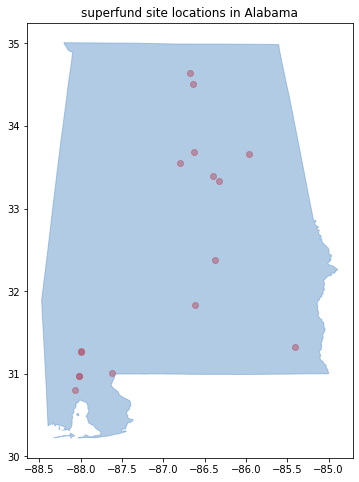

In [ ]:
# Get the geojson for the selected place from the Data Commons Graph
place_map = dc.get_property_values([place_dcid], prop='geoJsonCoordinates', out=True)[place_dcid][0]
place_map = json.loads(place_map)

# set the colors and initialize the empty figure object for drawing the map
BLUE = '#6699cc'
fig = plt.figure(figsize=(12, 8)) 
ax = fig.gca() 

# Draw the geojson fetched from the Data Commons Graph
ax.add_patch(PolygonPatch(place_map, fc=BLUE, ec=BLUE, alpha=0.5, zorder=2 ))
ax.axis('scaled')

# Add the locations of the superfund sites from the GeoDataFrame
gdf.plot(ax=ax, color='red', alpha = 0.5)
plt.title (f'superfund site locations in {selected_place_choice}')
plt.show()

## Demo 3 - Lookup timeseries for a specific superfund site

In this demo example, we will dive into accessing StatVarObservations for Statistical Variables related to superfund sites.

Currently, the Data Commons graph has the following statistics about superfund sites.

### For all superfund sites on the NPL

|Statistical Variable|Data Source|Status|
|-------|-----------|------|
|[CRSI Score](https://datacommons.org/browser/CrsiScore_SuperfundSite)|[Intersection of Natural Hazard Vulnerability and Superfund Site Location](https://catalog.data.gov/dataset/intersection-of-natural-hazard-vulnerability-and-superfund-site-location)|Available|
|[Natural Hazard Exposure Score](https://datacommons.org/browser/NaturalHazardExposureScore_SuperfundSite)|[Intersection of Natural Hazard Vulnerability and Superfund Site Location](https://catalog.data.gov/dataset/intersection-of-natural-hazard-vulnerability-and-superfund-site-location)|Available|
|[Natural Hazard Risk Score](https://datacommons.org/browser/NaturalHazardRiskScore_SuperfundSite)|[Intersection of Natural Hazard Vulnerability and Superfund Site Location](https://catalog.data.gov/dataset/intersection-of-natural-hazard-vulnerability-and-superfund-site-location)|Available|
|[`Natural Hazard Risk Score by <Meteorological Events>`](https://datacommons.org/browser/NaturalHazardRiskScore_SuperfundSite_WildfireEvent)|[Intersection of Natural Hazard Vulnerability and Superfund Site Location](https://catalog.data.gov/dataset/intersection-of-natural-hazard-vulnerability-and-superfund-site-location)|Available|

### Statistics available for Tar Creek superfund site

Statistics for the  Tar Creek superfund site are obtained the [6th five-year review report](https://semspub.epa.gov/work/06/100021610.pdf).This report measures concentration of contaminants in GroundWater across sampling wells withing and across the site. The concentration of contaminants are presented as [Total concentration](https://datacommons.org/browser/Concentration_Iron_BodyOfWater_GroundWater) and [Dissolved concentration](https://datacommons.org/browser/Concentration_DissolvedContaminant_Iron_BodyOfWater_GroundWater) statistical variables for:
- [Iron](https://datacommons.org/browser/Concentration_Iron_BodyOfWater_GroundWater)
- [Zinc](https://datacommons.org/browser/Concentration_Zinc_BodyOfWater_GroundWater)
- [Lead](https://datacommons.org/browser/Concentration_Lead_BodyOfWater_GroundWater)
- [Cadmium](https://datacommons.org/browser/Concentration_Cadmium_BodyOfWater_GroundWater)
- [Sulfate](https://datacommons.org/browser/Concentration_Sulfate_BodyOfWater_GroundWater)

The report also has
measurements on water properties in GroundWaterlike:
- [hardness](https://datacommons.org/browser/WaterHardness_BodyOfWater_GroundWater)
- [pH](https://datacommons.org/browser/otentialOfHydrogen_BodyOfWater_GroundWater)
- [dissolved oxygen](https://datacommons.org/browser/DissolvedOxygen_BodyOfWater_GroundWater)
- [electrical conductivity](https://datacommons.org/browser/ElectricalConductivity_BodyOfWater_GroundWater)
- [temperature](https://datacommons.org/browser/Temperature_BodyOfWater_GroundWater)

The statistics are available for 4 sampling wells across Tar Creek namely: [Quapaw #4](https://datacommons.org/browser/epaSuperfundMeasurementSite/OKD980629844/Quapaw_4), [Commerce #5](https://datacommons.org/browser/epaSuperfundMeasurementSite/OKD980629844/Commerce_5), [Picher #5](https://datacommons.org/browser/epaSuperfundMeasurementSite/OKD980629844/Picher_5-MW) and [Picher #7](https://datacommons.org/browser/epaSuperfundMeasurementSite/OKD980629844/Picher_7-MW)

### Accessing and Visualizing Statistics for Tar Creek

In [ ]:
## get a list of measurement sites that are in and around Tar Creek
tar_creek = 'epaSuperfundSiteId/OKD980629844'
measurement_sites = dc.get_places_in([tar_creek], 'SuperfundMeasurementSite')[tar_creek]
measurement_sites

['epaSuperfundMeasurementSite/OKD980629844/Commerce_5',
 'epaSuperfundMeasurementSite/OKD980629844/Picher_5-MW',
 'epaSuperfundMeasurementSite/OKD980629844/Picher_7-MW',
 'epaSuperfundMeasurementSite/OKD980629844/Quapaw_4']

List of statistical variables that are available for a measurement site can be obtained on the Graph Browser page for measurement sites ([example](https://datacommons.org/browser/epaSuperfundMeasurementSite/OKD980629844/Picher_7-MW)).

In [ ]:
# List of statistics that are available for each measurement site
measurement_sites_statvars_list = ['Concentration_Sulfate_BodyOfWater_GroundWater',
                                   'Concentration_Lead_BodyOfWater_GroundWater',
                                   'Concentration_Cadmium_BodyOfWater_GroundWater',
                                   'Concentration_DissolvedContaminant_Cadmium_BodyOfWater_GroundWater',
                                   'Concentration_DissolvedContaminant_Iron_BodyOfWater_GroundWater',
                                   'Concentration_DissolvedContaminant_Lead_BodyOfWater_GroundWater',
                                   'Concentration_DissolvedContaminant_Zinc_BodyOfWater_GroundWater',
                                   'Concentration_Iron_BodyOfWater_GroundWater',
                                   'DissolvedOxygen_BodyOfWater_GroundWater',
                                   'Concentration_Zinc_BodyOfWater_GroundWater',
                                   'PotentialOfHydrogen_BodyOfWater_GroundWater',
                                   'ElectricalConductivity_BodyOfWater_GroundWater',
                                   'Temperature_BodyOfWater_GroundWater',
                                   'WaterHardness_BodyOfWater_GroundWater']

Now, we will be to query the Data Commons graph for all statistics available for a particular sampling well and a particular statistical variable.

Please note that statistics for Tar Creek are time-series of observed characteristics of contaminated ground water and the concentration of different contaminants. The following code snippet uses the [`build_time_series_dataframe`](https://docs.datacommons.org/api/pandas/time_series_dataframe.html) API method to show one statistical variables available from the above list for the sampling well called [`Quapaw #4`](https://datacommons.org/browser/epaSuperfundMeasurementSite/OKD980629844/Quapaw_4) near Tar Creek.

In [ ]:
tar_creek_contamiantion_statvar_df = dpd.build_time_series_dataframe(['epaSuperfundMeasurementSite/OKD980629844/Quapaw_4'], measurement_sites_statvars_list[0])

tar_creek_contamiantion_statvar_df.head(5)

,2003-11-06,2004-04-28,2004-10-13,2005-04-26,2005-10-18,2006-04-12,2006-11-09,2007-05-09,2007-10-24,2008-04-22,2010-03-25,2010-11-11,2011-11-03,2012-11-08,2013-10-31,2017-03-14,2018-04-25,2019-04-30
place,,,,,,,,,,,,,,,,,,
epaSuperfundMeasurementSite/OKD980629844/Quapaw_4,11.1,11.8,12.8,13.5,16.4,15.2,20,12.6,14.3,13.2,14.8,15.7,14.3,15.7,14.3,16.3,18.8,15.6


### Accessing and visualizing statistics available for all superfund sites in Data Commons

Next, we shall use the list of statistical variables for a superfund site, we can now make visualizations of the different StatVarObservations that are made for superfund sites.

We fetch the time-series of StatVarObservations using the [`pandas`](https://docs.datacommons.org/api/pandas) API method [`build_time_series_dataframe`](https://docs.datacommons.org/api/pandas/time_series_dataframe.html) which returns a pandas datafarme of the time-series that are available for a particular place and a particular statistical variable.

In [ ]:
print("Select a statistical variable")

# list of statistical variables that we shall use for this notebook
stat_var_list = [
    'CrsiScore_SuperfundSite',
    'NaturalHazardExposureScore_SuperfundSite',
    'NaturalHazardRiskScore_SuperfundSite',
    'NaturalHazardRiskScore_SuperfundSite_CoastalFloodEvent',
    'NaturalHazardRiskScore_SuperfundSite_DroughtEvent',
    'NaturalHazardRiskScore_SuperfundSite_EarthquakeEvent',
    'NaturalHazardRiskScore_SuperfundSite_ExcessiveHeatEvent',
    'NaturalHazardRiskScore_SuperfundSite_ExtremeColdWindChillEvent',
    'NaturalHazardRiskScore_SuperfundSite_FloodEvent',
    'NaturalHazardRiskScore_SuperfundSite_HailEvent',
    'NaturalHazardRiskScore_SuperfundSite_HighWindEvent',
    'NaturalHazardRiskScore_SuperfundSite_HurricaneEvent',
    'NaturalHazardRiskScore_SuperfundSite_LandslideEvent',
    'NaturalHazardRiskScore_SuperfundSite_TornadoEvent',
    'NaturalHazardRiskScore_SuperfundSite_WildfireEvent'
 ]
# Populating the select dropdown
stat_var_select = widgets.Dropdown(options=stat_var_list, value=stat_var_list[0])
display(stat_var_select)

Select a statistical variable


Dropdown(options=('CrsiScore_SuperfundSite', 'NaturalHazardExposureScore_SuperfundSite', 'NaturalHazardRiskSco…

In [ ]:
stat_var_list

In [ ]:
chosen_statvar = stat_var_select.value
site_statvar_df = dpd.build_time_series_dataframe([site_dcid], chosen_statvar)
site_statvar_df.head(5)

,2021
place,
epaSuperfundSiteId/AL3210020027,0.327246


#### Getting statistics to a `pandas` DataFrame
Using the same `build_time_series_dataframe` API method, get the StatVarObservations for the selected statistical variable across all superfund sites.

In [ ]:
site_statvar_df = dpd.build_time_series_dataframe(superfund_sites, chosen_statvar)
site_statvar_df.head(5)

,2021
place,
epaSuperfundSiteId/AL3210020027,0.327246
epaSuperfundSiteId/AL6210020008,0.600902
epaSuperfundSiteId/AL7210020742,0.610158
epaSuperfundSiteId/ALD001221902,0.962115
epaSuperfundSiteId/ALD004022448,0.951963


In both examples, the dataframe is still not human readable, let us add the name to the superfund sites. To add the names to the dataframe, we will query the superfund site's node and extract the `name` property using the `get_property_values` API method.

In [ ]:
def add_name_col(df):
  # Add a new column called name, where each value is the name for the place dcid in the index.
  df['name'] = df.index.map(dc.get_property_values(df.index, 'name'))
  
  # Keep just the first name, instead of a list of all names.
  df['name'] = df['name'].str[0]

add_name_col(site_statvar_df)
site_statvar_df.head()

,2021,name
place,,
epaSuperfundSiteId/AL3210020027,0.327246,Anniston Army Depot (Southeast Industrial Area)
epaSuperfundSiteId/AL6210020008,0.600902,Alabama Army Ammunition Plant
epaSuperfundSiteId/AL7210020742,0.610158,Redstone Arsenal (USARMY/NASA)
epaSuperfundSiteId/ALD001221902,0.962115,Ciba-Geigy Corp. (McIntosh Plant)
epaSuperfundSiteId/ALD004022448,0.951963,Alabama Plating Company Inc.


#### Visualizing StatVarObservations for superfund site statistics
Now, let us try visualizing the StatVarObservations.


The statistical variables that are currently available on superfund sites across the country is from the [Intersection of Natural Hazard Vulnerability and Superfund Site Location](https://catalog.data.gov/dataset/intersection-of-natural-hazard-vulnerability-and-superfund-site-location) paper and has only one data-point. 

Hence, we visualize the sites with highest natural hazard vulnerability as a bar chart.

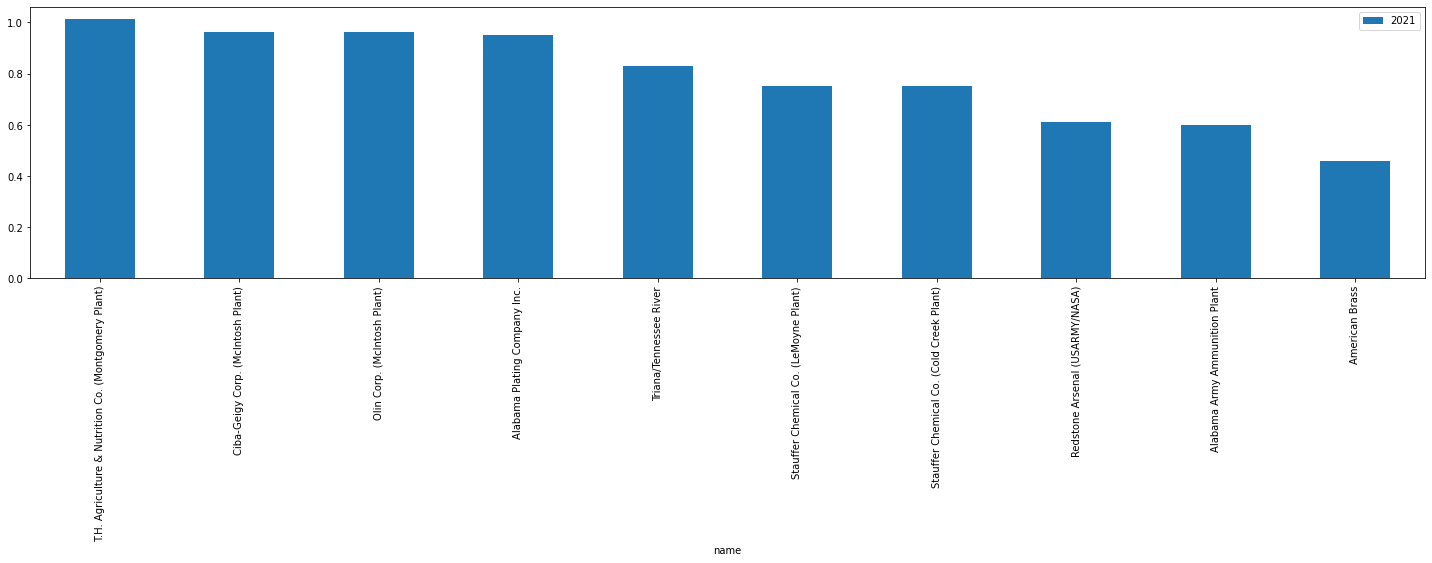

In [ ]:
# sort the dataframe by the value column in descending order
site_vulnerability = site_statvar_df.sort_values(by='2021', ascending=False)

# set the threshold on the number sites to visualize - since there are 1,300 odd superfund sites
num_sites = 10
site_vulnerability = site_vulnerability[:num_sites]
site_vulnerability.plot(kind='bar', x='name', y='2021', figsize=(25,5))

If two statistical variables need to be compared together for correlations for a particular place, please consider using the [`build_multivariate_dataframe`](https://docs.datacommons.org/api/pandas/multivariate_dataframe.html) API method.

For example, we shall compare the CRSI score (stat_var_id: `CrsiScore_SuperfundSite`) with the natural hazard risk score (stat_var_id: `NaturalHazardRiskScore_SuperfundSite`) across superfund sites in the US.

> The [Climate Resilience Screening Index](https://www.iisd.org/system/files/meterial/US%20EPA%20CSIN%20webinar%203.pdf) (CRSI) score which measures the resilience of socio-ecological systems, (superfund sites) in the context of governance and risk to natural hazard events.



In [ ]:
multi_statvar_df = dpd.build_multivariate_dataframe(superfund_sites,["CrsiScore_SuperfundSite", "NaturalHazardRiskScore_SuperfundSite"])
multi_statvar_df

,NaturalHazardRiskScore_SuperfundSite,CrsiScore_SuperfundSite
place,,
epaSuperfundSiteId/AL3210020027,66.945,0.327246
epaSuperfundSiteId/AL6210020008,30.332,0.600902
epaSuperfundSiteId/AL7210020742,80.383,0.610158
epaSuperfundSiteId/ALD001221902,35.174,0.962115
epaSuperfundSiteId/ALD004022448,53.149,0.951963
epaSuperfundSiteId/ALD007454085,51.894,1.011869
epaSuperfundSiteId/ALD008161176,53.565,0.750292
epaSuperfundSiteId/ALD008188708,35.174,0.962115
epaSuperfundSiteId/ALD041906173,91.456,0.394343


For the comparison, we shall make a scatter plot across the two statistical variables namely: "CrsiScore_SuperfundSite" and "NaturalHazardRiskScore_SuperfundSite"

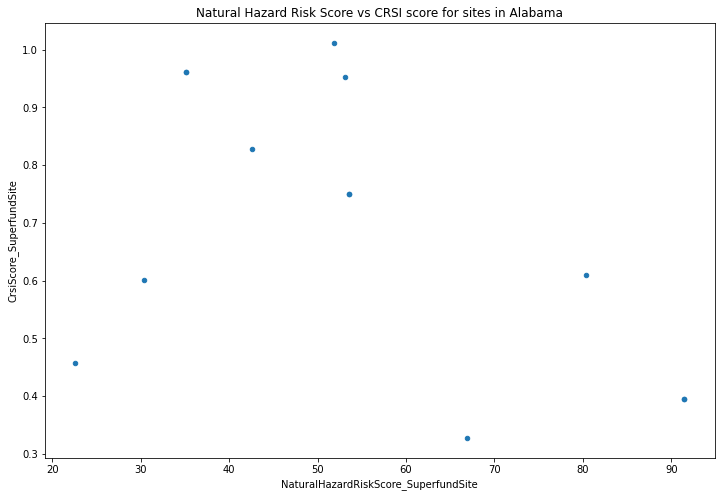

In [ ]:
# Scatter plot the information
multi_statvar_df.plot(kind='scatter', x='NaturalHazardRiskScore_SuperfundSite', y='CrsiScore_SuperfundSite', figsize=(12, 8))
plt.title(f"Natural Hazard Risk Score vs CRSI score for sites in {selected_place_choice}")
plt.xlabel("NaturalHazardRiskScore_SuperfundSite")
plt.ylabel("CrsiScore_SuperfundSite")
plt.show()

## Demo 4 - Comparing superfund statistics with other statistics in Data Commons

This demo example is probably the most interesting one since, we will compare superfund statistics with other statistics in Data Commons. 

In this example, we will compare the `CRSI score` of a superfund site and the impact seen on the tribal population living in cities in and around the site. The tribal population statistics come from the US census and the CRSI score is the same statistical variable we used in the previous examples.

This is advantage which Data Commons offers, where it is easy to make such cross-domain, cross-place, cross-statistics analysis.


Before making the visualization let us first take a look at how the dataset will look and what will the pre-processing that is required

In [ ]:
superfund_sites = dc.get_places_in([place_dcid], 'SuperfundSite')[place_dcid]
dpd.build_time_series_dataframe(superfund_sites, 'CrsiScore_SuperfundSite').head(5)

,2021
place,
epaSuperfundSiteId/AL3210020027,0.327246
epaSuperfundSiteId/AL6210020008,0.600902
epaSuperfundSiteId/AL7210020742,0.610158
epaSuperfundSiteId/ALD001221902,0.962115
epaSuperfundSiteId/ALD004022448,0.951963


In [ ]:
cities = dpd.get_places_in([place_dcid], 'City')[place_dcid]
dpd.build_time_series_dataframe(cities, 'Count_Person_AmericanIndianAndAlaskaNativeAlone').head(5)

,2000,2010,2020
place,,,
geoId/0100100,NaN,0.0,0.0
geoId/0100124,0.0,2.0,5.0
geoId/0100460,20.0,23.0,31.0
geoId/0100484,1.0,0.0,9.0
geoId/0100676,0.0,0.0,0.0


From the two dataframes, it is clear that we have statistics from different years and the number of places across the two dataframes are not consistent.

Let's get started....

#### Understanding the hierarchy in which places are nested in Data Commons

For getting the city which has a superfund site, we will be using the `site_df` dataframe, which we created in the begining. This dataframe has a column called `containedInPlace` which is a list.

An example of the `containedInPlace` list looks as follows:
```python
['geoId/01',
 'geoId/01015',
 'geoId/0101590099',
 'geoId/01015981901',
 'geoId/0103']
```
The list essentially lists the place ids based on the administrative area division. An example of getting the `typeOf` places for a list of place ids is shown as an example in the beginning sections of the notebook.

In this case, the interpretation of the list is done as follows:
```python
['geoId/01', #state's place_id
 'geoId/01015', # county's place_id
 'geoId/0101590099', # city's place_id
 'geoId/01015981901', # census tract's place_id
 'geoId/0103' # congressional district's place_id
 ]
```

### Preparing the datasets for comparison
From this list we pick the third element which corresponds to the city's place_id.

> The structure of this list is consistent at the high-level some sites have finer geo-level like Zip Code Tabulation Area (ZCTA) codes.

First let us make a dataframe based off the `site_df` dataframe. To this dataframe, we will add different statistics which we will visualize.

The recipe we plan to do is the following:
1. From the `site_df` dataframe, create a new dataframe where the superfund sites are located in a city.
2. To this dataframe, we shall merge the StatVarObservations for the `CrsiScore_SuperfundSite` statistical variable based on the superfund site id
3. To the merged dataframe, we shall do another merge but this time with StatVarObservations for the `Count_Person_AmericanIndianAndAlaskaNativeAlone` statistical variable based on the `containedInPlace` city id
4. Visualize!

In [ ]:
## Step 1: Making dataframe with the superfund site id and the id of the city where the site is present
def get_city_id(elem_list, fips_code_len=7):
  for e in elem_list:
    if len(e.split('/')[1]) == fips_code_len:
      return e
  return ''

site_place_df = site_df[['epaSuperfundSiteId', 'containedInPlace']]
site_place_df['epaSuperfundSiteId'] = site_place_df['epaSuperfundSiteId'].apply(lambda elem: 'epaSuperfundSiteId/' + elem)
site_place_df['containedInPlace'] = site_place_df['containedInPlace'].apply(get_city_id)
site_place_df = site_place_df[site_place_df['containedInPlace'] != '']
site_place_df

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,epaSuperfundSiteId,containedInPlace
1,epaSuperfundSiteId/AL6210020008,geoId/0114464
4,epaSuperfundSiteId/ALD004022448,geoId/0179008
5,epaSuperfundSiteId/ALD007454085,geoId/0151000
8,epaSuperfundSiteId/ALD031618069,geoId/0131912
9,epaSuperfundSiteId/ALD041906173,geoId/0115256
11,epaSuperfundSiteId/ALD980728703,geoId/0159064
12,epaSuperfundSiteId/ALD980844385,geoId/0168160
13,epaSuperfundSiteId/ALD981868466,geoId/0133856
15,epaSuperfundSiteId/ALN000410750,geoId/0107000


In [ ]:
# Step 2: Merging the StatVarObservations for the `CrsiScore_SuperfundSite` statistical variable to `site_data_df`
site_data_df = site_place_df.copy()
# Get the list of superfundsites that are contained in a city
contained_site_list = site_data_df['epaSuperfundSiteId'].values.tolist()
# with the list of superfund sites' place_ids query Data Commons to stats for CrsiScore_SuperfundSite statistical variable
superfund_data_df = dpd.build_time_series_dataframe(contained_site_list, 'CrsiScore_SuperfundSite')
# rename the column to make it readable
superfund_data_df.columns = ['CrsiScore_SuperfundSite']
# merge
site_data_df = pd.merge(site_data_df, superfund_data_df, left_on='epaSuperfundSiteId', right_on='place', how='left')


# Step 3: Merging the StatVarObservations for the `Count_Person_AmericanIndianAndAlaskaNativeAlone` statistical variable to `site_data_df`
# Get the list of cities that have superfund sites
contained_cities_list = site_data_df['containedInPlace'].values.tolist()
# with the list of cities' place_ids query Data Commons to stats for Count_Person_AmericanIndianAndAlaskaNativeAlone statistical variable
demographic_data_df = dpd.build_time_series_dataframe(contained_cities_list, 'Count_Person_AmericanIndianAndAlaskaNativeAlone')
# merge
site_data_df = pd.merge(site_data_df, demographic_data_df, left_on='containedInPlace', right_on='place', how='left')
site_data_df

,epaSuperfundSiteId,containedInPlace,CrsiScore_SuperfundSite,2000,2010,2020
0,epaSuperfundSiteId/AL6210020008,geoId/0114464,0.600902,16.0,21.0,8
1,epaSuperfundSiteId/ALD004022448,geoId/0179008,0.951963,14.0,7.0,10
2,epaSuperfundSiteId/ALD007454085,geoId/0151000,1.011869,500.0,512.0,713
3,epaSuperfundSiteId/ALD031618069,geoId/0131912,NaN,20.0,4.0,9
4,epaSuperfundSiteId/ALD041906173,geoId/0115256,0.394343,15.0,29.0,38
5,epaSuperfundSiteId/ALD980728703,geoId/0159064,NaN,NaN,NaN,21
6,epaSuperfundSiteId/ALD980844385,geoId/0168160,NaN,69.0,104.0,228
7,epaSuperfundSiteId/ALD981868466,geoId/0133856,0.458104,7.0,18.0,6
8,epaSuperfundSiteId/ALN000410750,geoId/0107000,0.394343,422.0,445.0,755


#### Example to create custom data aggregations and normalizations

We have the dataset where the superfund related statistic ranges from 0-1 but the count of the American Indian and Alaska Native population is an absolute value. We will need to normalize the count of the American Indian and Alaska Native population with the total population in the selected place. 

This can done easily with the [`build_multivaritate_dataframe`](https://docs.datacommons.org/api/pandas/multivariate_dataframe.html) API method as shown in the following code snippet.

In [ ]:
# api call to get the total population and population of the American Indian and Alaska Natives
multivariate_dataframe = dpd.build_multivariate_dataframe(places=contained_cities_list, stat_vars=['Count_Person', 'Count_Person_AmericanIndianAndAlaskaNativeAlone'])
multivariate_dataframe = multivariate_dataframe.reset_index()

# computing per capita population
multivariate_dataframe['perCapitaPopulation'] = multivariate_dataframe['Count_Person_AmericanIndianAndAlaskaNativeAlone'] / multivariate_dataframe['Count_Person']

# merge the computed per_capita values to the site_data_df
site_data_df = pd.merge(site_data_df, multivariate_dataframe[['place', 'perCapitaPopulation']], left_on='containedInPlace', right_on='place', how='left')
site_data_df

,epaSuperfundSiteId,containedInPlace,CrsiScore_SuperfundSite,2000,2010,2020,place,perCapitaPopulation
0,epaSuperfundSiteId/AL6210020008,geoId/0114464,0.600902,16.0,21.0,8,geoId/0114464,0.001683
1,epaSuperfundSiteId/ALD004022448,geoId/0179008,0.951963,14.0,7.0,10,geoId/0179008,0.005045
2,epaSuperfundSiteId/ALD007454085,geoId/0151000,1.011869,500.0,512.0,713,geoId/0151000,0.003554
3,epaSuperfundSiteId/ALD031618069,geoId/0131912,NaN,20.0,4.0,9,geoId/0131912,0.001221
4,epaSuperfundSiteId/ALD041906173,geoId/0115256,0.394343,15.0,29.0,38,geoId/0115256,0.003693
5,epaSuperfundSiteId/ALD980728703,geoId/0159064,NaN,NaN,NaN,21,geoId/0159064,0.028767
6,epaSuperfundSiteId/ALD980844385,geoId/0168160,NaN,69.0,104.0,228,geoId/0168160,0.014099
7,epaSuperfundSiteId/ALD981868466,geoId/0133856,0.458104,7.0,18.0,6,geoId/0133856,0.001207
8,epaSuperfundSiteId/ALN000410750,geoId/0107000,0.394343,422.0,445.0,755,geoId/0107000,0.003761


## Visualizing the comparison on a scatter plot

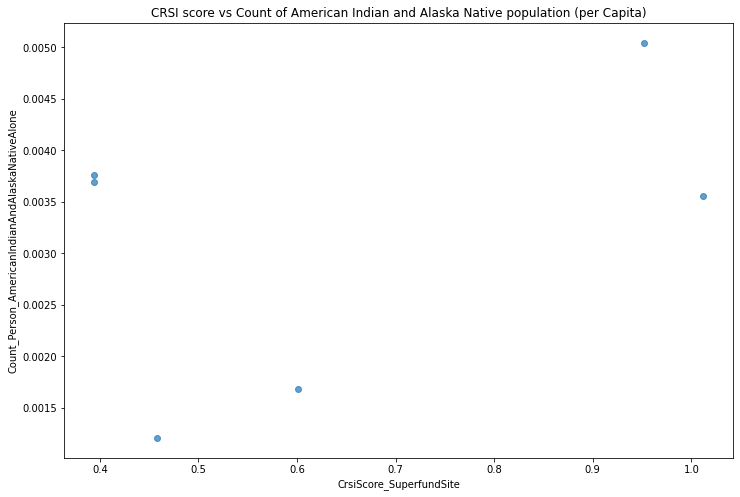

In [ ]:
def plot_data(title, pd_table, x, y):
  """ Generate a scatter plot comparing CrsiScore_SuperfundSite and Count_Person_AmericanIndianAndAlaskaNativeAlone. """
  plt.figure(figsize=(12, 8))
  plt.title(title)
  plt.xlabel('CrsiScore_SuperfundSite')
  plt.ylabel('Count_Person_AmericanIndianAndAlaskaNativeAlone')
  
  # Scatter plot the information
  ax = plt.gca()
  ax.scatter(pd_table[x], pd_table[y], alpha=0.7)

# Generate the plot for state data
title = 'CRSI score vs Count of American Indian and Alaska Native population (per Capita)'
plot_data(title, site_data_df, x='CrsiScore_SuperfundSite', y='perCapitaPopulation')

### What's Next?
Congratulations 🎉 on completing the tutorial. Next, please free to explore other Data Commons notebooks to get ideas for querying and joining data from the graph